# Infer CNV using the original infercnvpy package as a baseline method on the Benchmark dataset

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
from collections.abc import Sequence
import windowCNV as wcnv

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

/opt/anaconda3/envs/windowcnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the example dataset and Pre-processing

In [2]:
adata = sc.read_h5ad('/users/carolli/Desktop/CSCB/Final/PBMC_simulated_cnas_041025.h5ad')

In [3]:
adata.var.loc[:, ["chromosome", "start", "end"]].head()

,chromosome,start,end
original_index,,,
AL627309.1,NaN,NaN,NaN
AL627309.3,1,89551.0,91105.0
AL669831.5,1,778739.0,810066.0
FAM87B,1,817363.0,819842.0
LINC00115,1,586945.0,827989.0


In [4]:
# keep cells with fewer than 20% mitochondrially encoded gene total UMIs
adata = adata[adata.obs['pct_counts_mt']<20,:].copy()

# filter based on total number of genes detected (at least 500).
sc.pp.filter_cells(adata, min_genes=500)
# filter based on total number of counts (fewer than than 30,000).
sc.pp.filter_cells(adata, max_counts=30000)
# keep genes that are detected in at least 3 cells.
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata , target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)

In [6]:
sc.tl.pca(adata , mask_var='highly_variable')

n_neighbors = 20
n_pcs = 10
# Compute the k-nearest neighbor graph using specified number of neighbors and principal components
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Perform Leiden clustering with the specified resolution
sc.tl.leiden(adata, .1)

# Compute the PAGA for trajectory inference
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)

# Compute the UMAP for 2D visualization using PAGA initialization
sc.tl.umap(adata, 0.25, init_pos='paga')

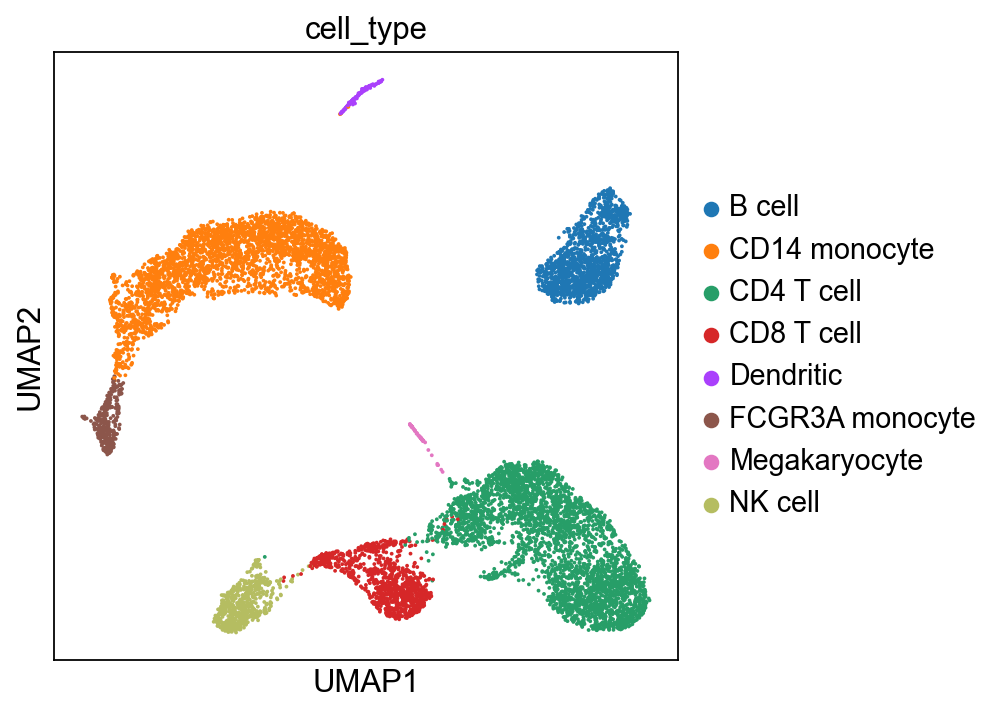

In [7]:
sc.pl.umap(adata, color="cell_type")

In [8]:
# Add 'chr' only if not present
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: x if str(x).startswith('chr') else f'chr{x}')

# Keep standard chromosomes chr1 - chr22 plus chrX and chrY
standard_chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

# Filter adata to only standard chromosomes
adata = adata[:, adata.var['chromosome'].isin(standard_chromosomes)].copy()

## Running original infercnv() function

Since we don't have the information for normal cell types, we'll treat them equally and use mean of all cells as reference.

In [9]:
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    window_size=250
)

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.80s/it]


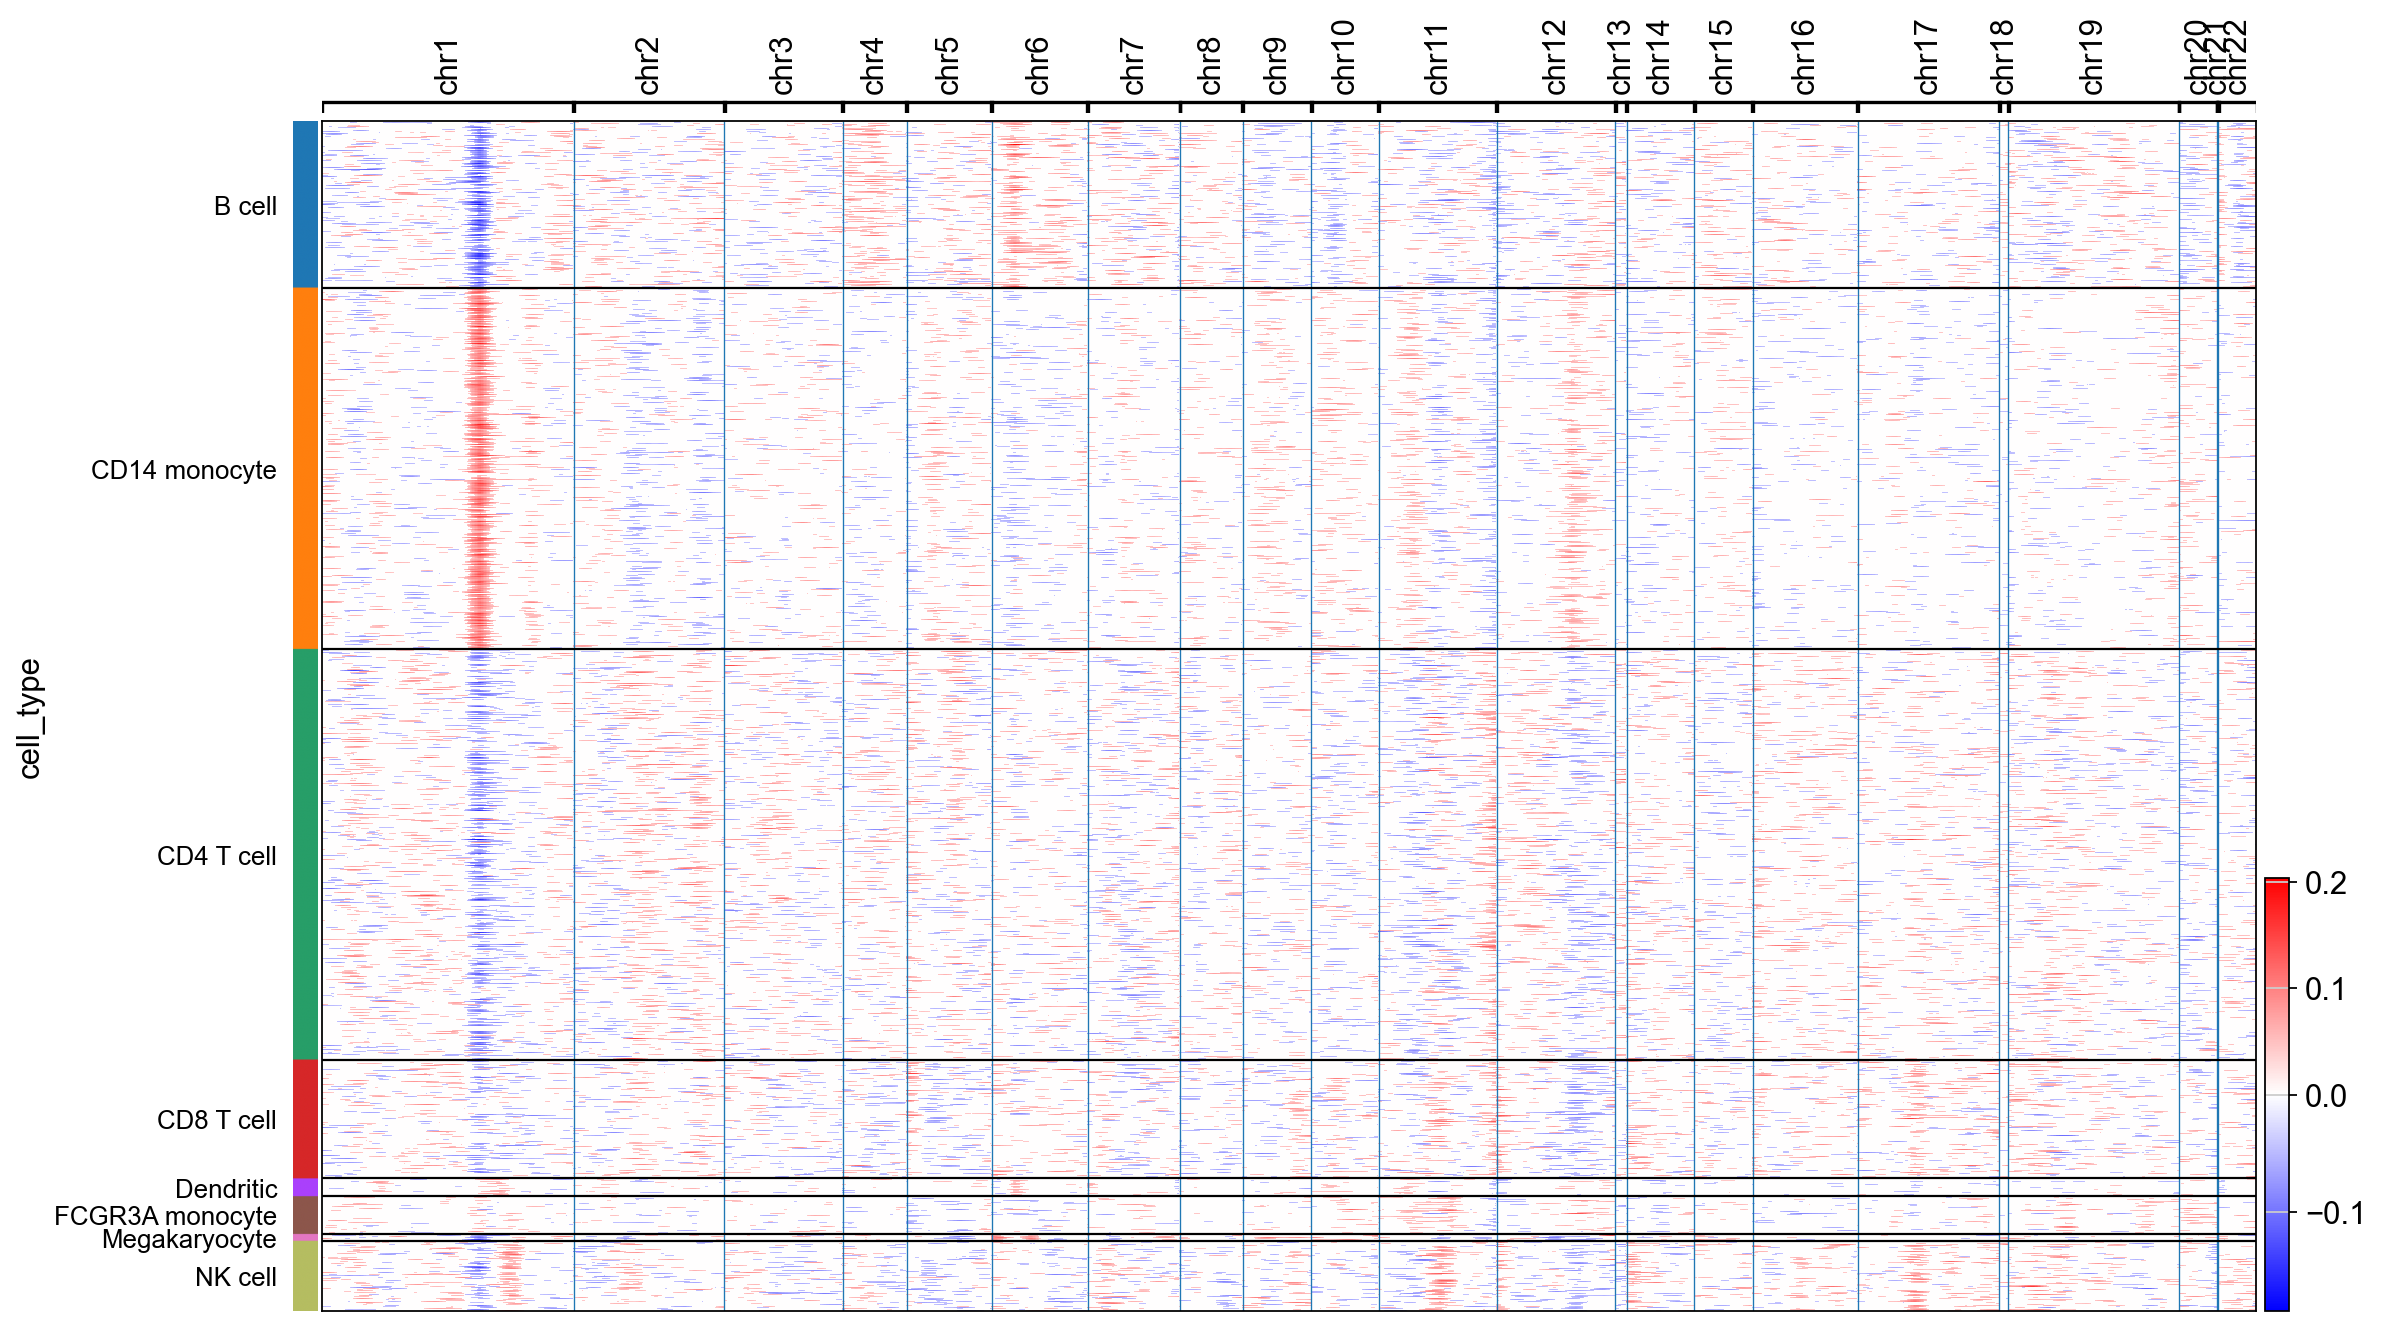

In [10]:
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

Based on the above figure, there isn't a cell type that is most subject to copy number variation. We can only observe that Dendritic and FCGR3A monocytes show less variation, and chr1 seems to experience more CNV than other chromosomes.

## Inspect cnv with functions in our new package

In [11]:
chromosome_map_df = wcnv.map_cnv_status_by_celltype(adata)
print(chromosome_map_df)

       Cell Type Chromosome   Gain   Loss
0     CD4 T cell       chrX   True  False
1  CD14 monocyte      chr22  False   True
2  CD14 monocyte       chr6  False   True


By this, we can have a clear overview of the simulated CNV events.

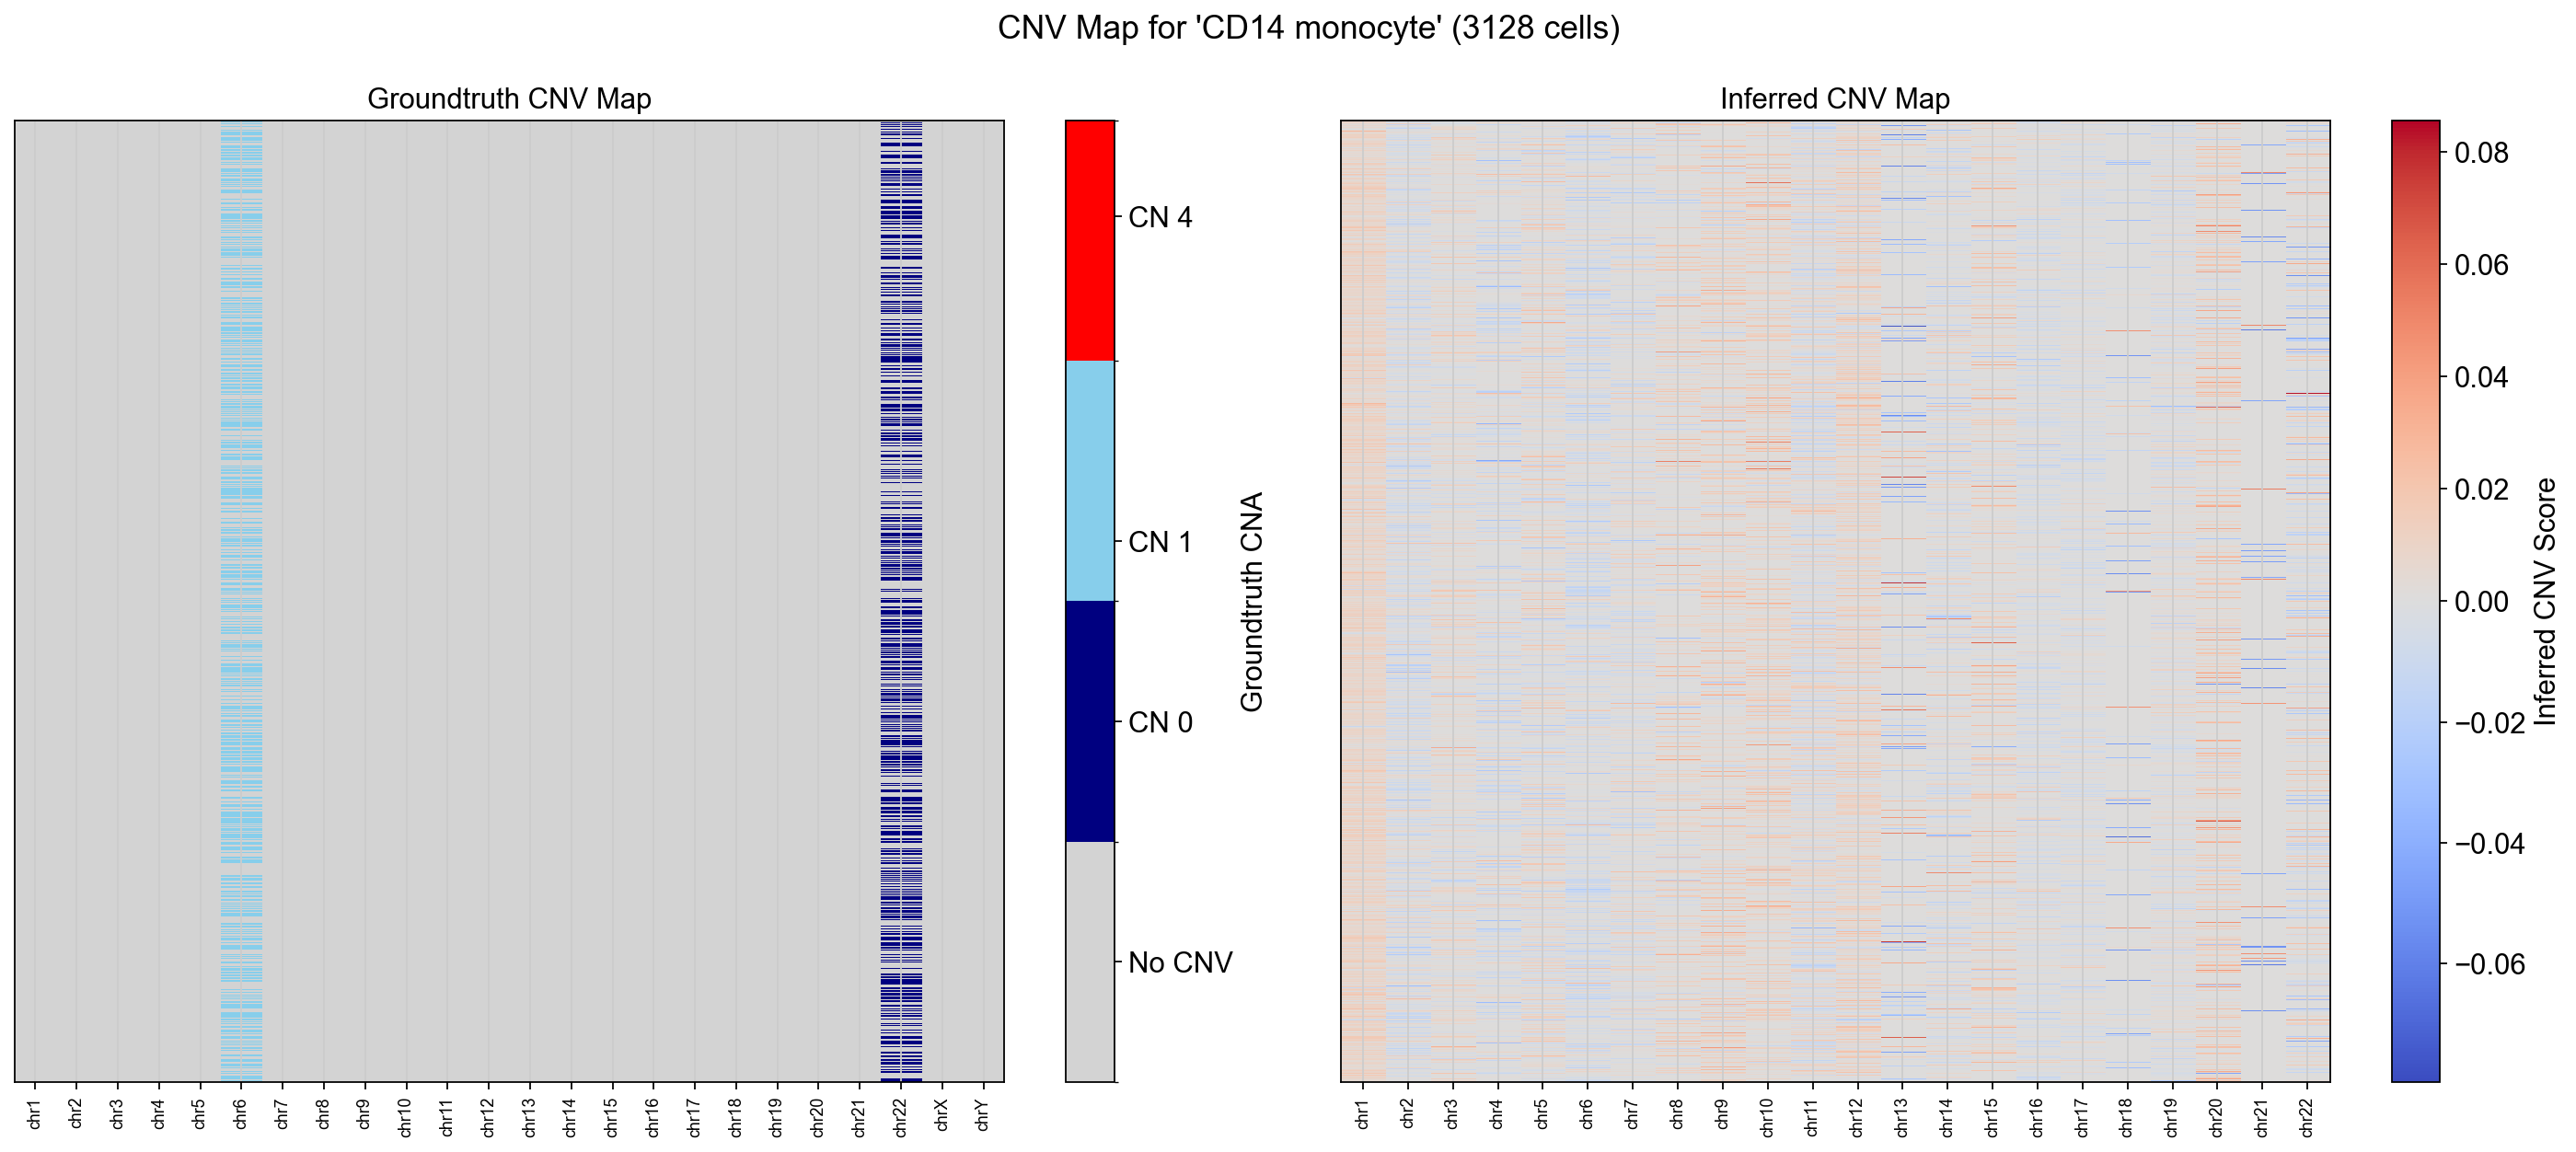

In [12]:
wcnv.plot_cnv_groundtruth_vs_inferred(
    adata,
    cell_type='CD14 monocyte',
    cnv_truth_key='simulated_cnvs',
    cnv_inferred_key='cnv'
)

To note, chrX and chrY are excluded. Though sometimes they might also experience CNV events, it's safer to exclude them when we want a better overview across all chromosomes. The two plots above show that the inferred CNVs don't correspond to the groundtruth very well.

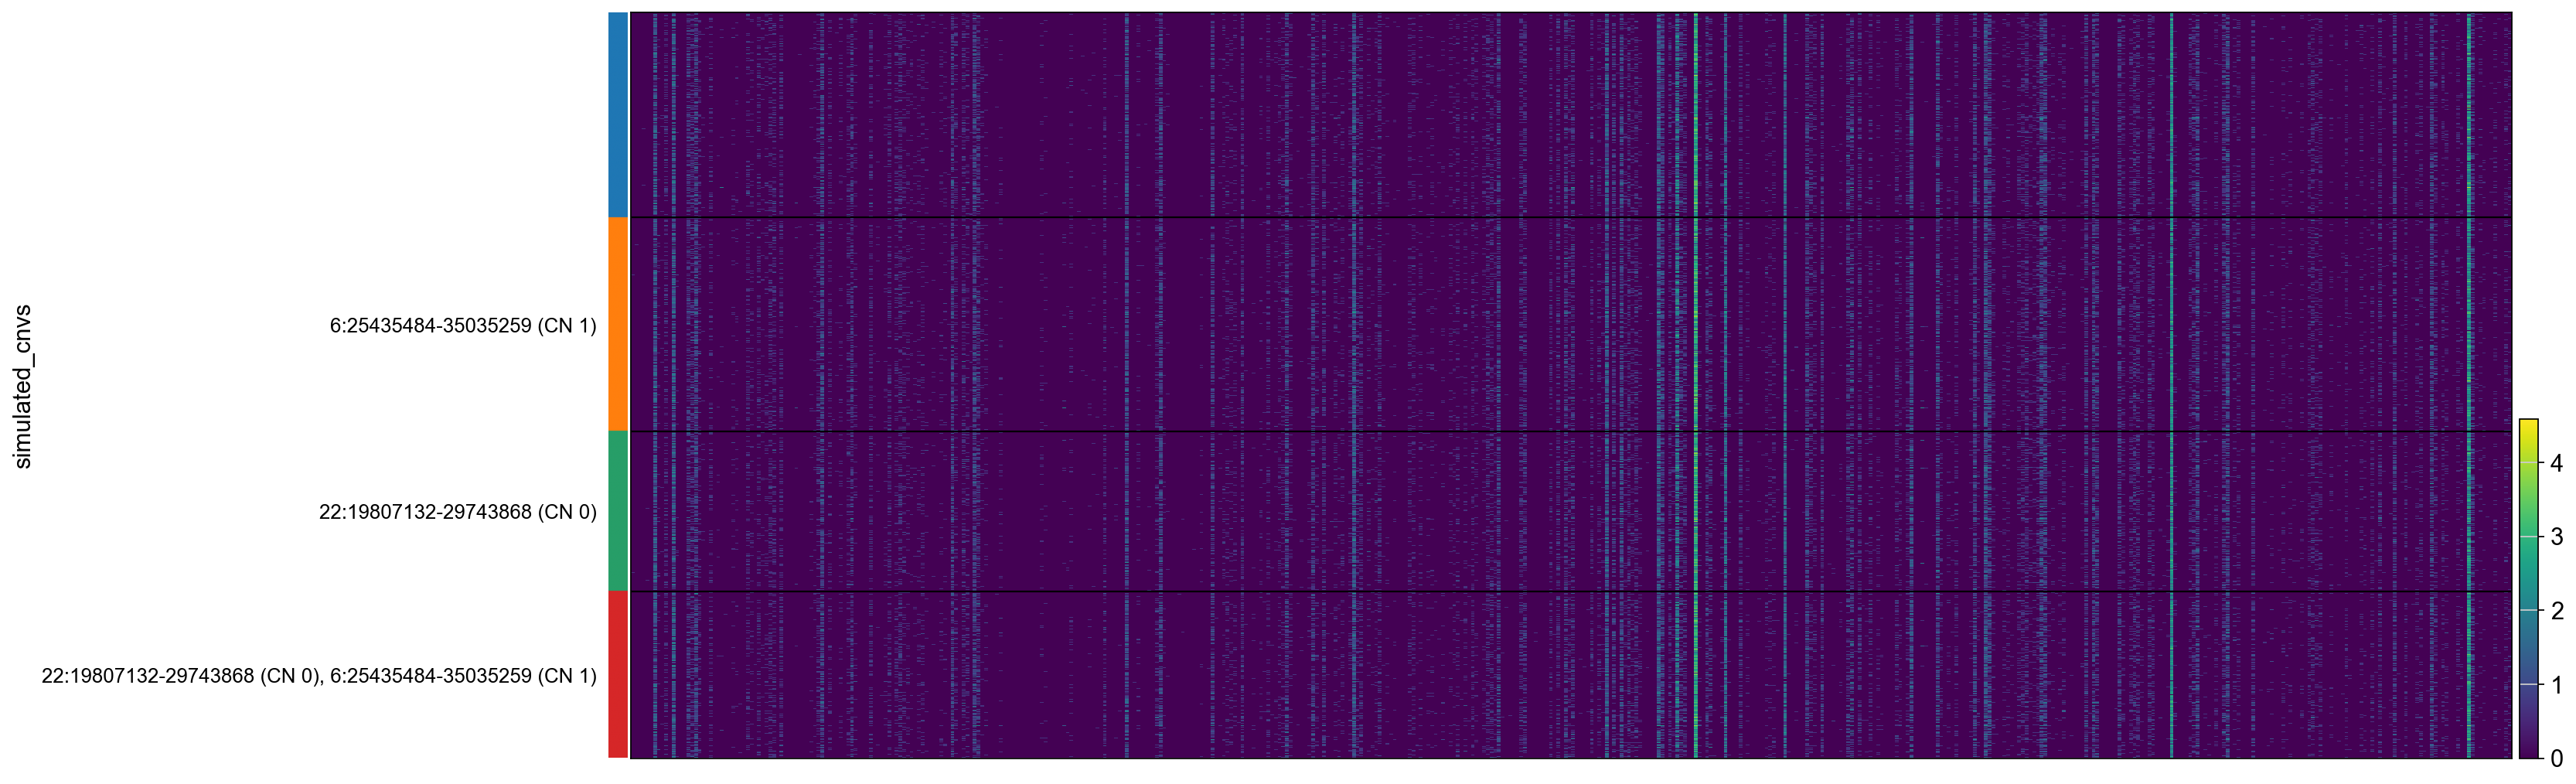

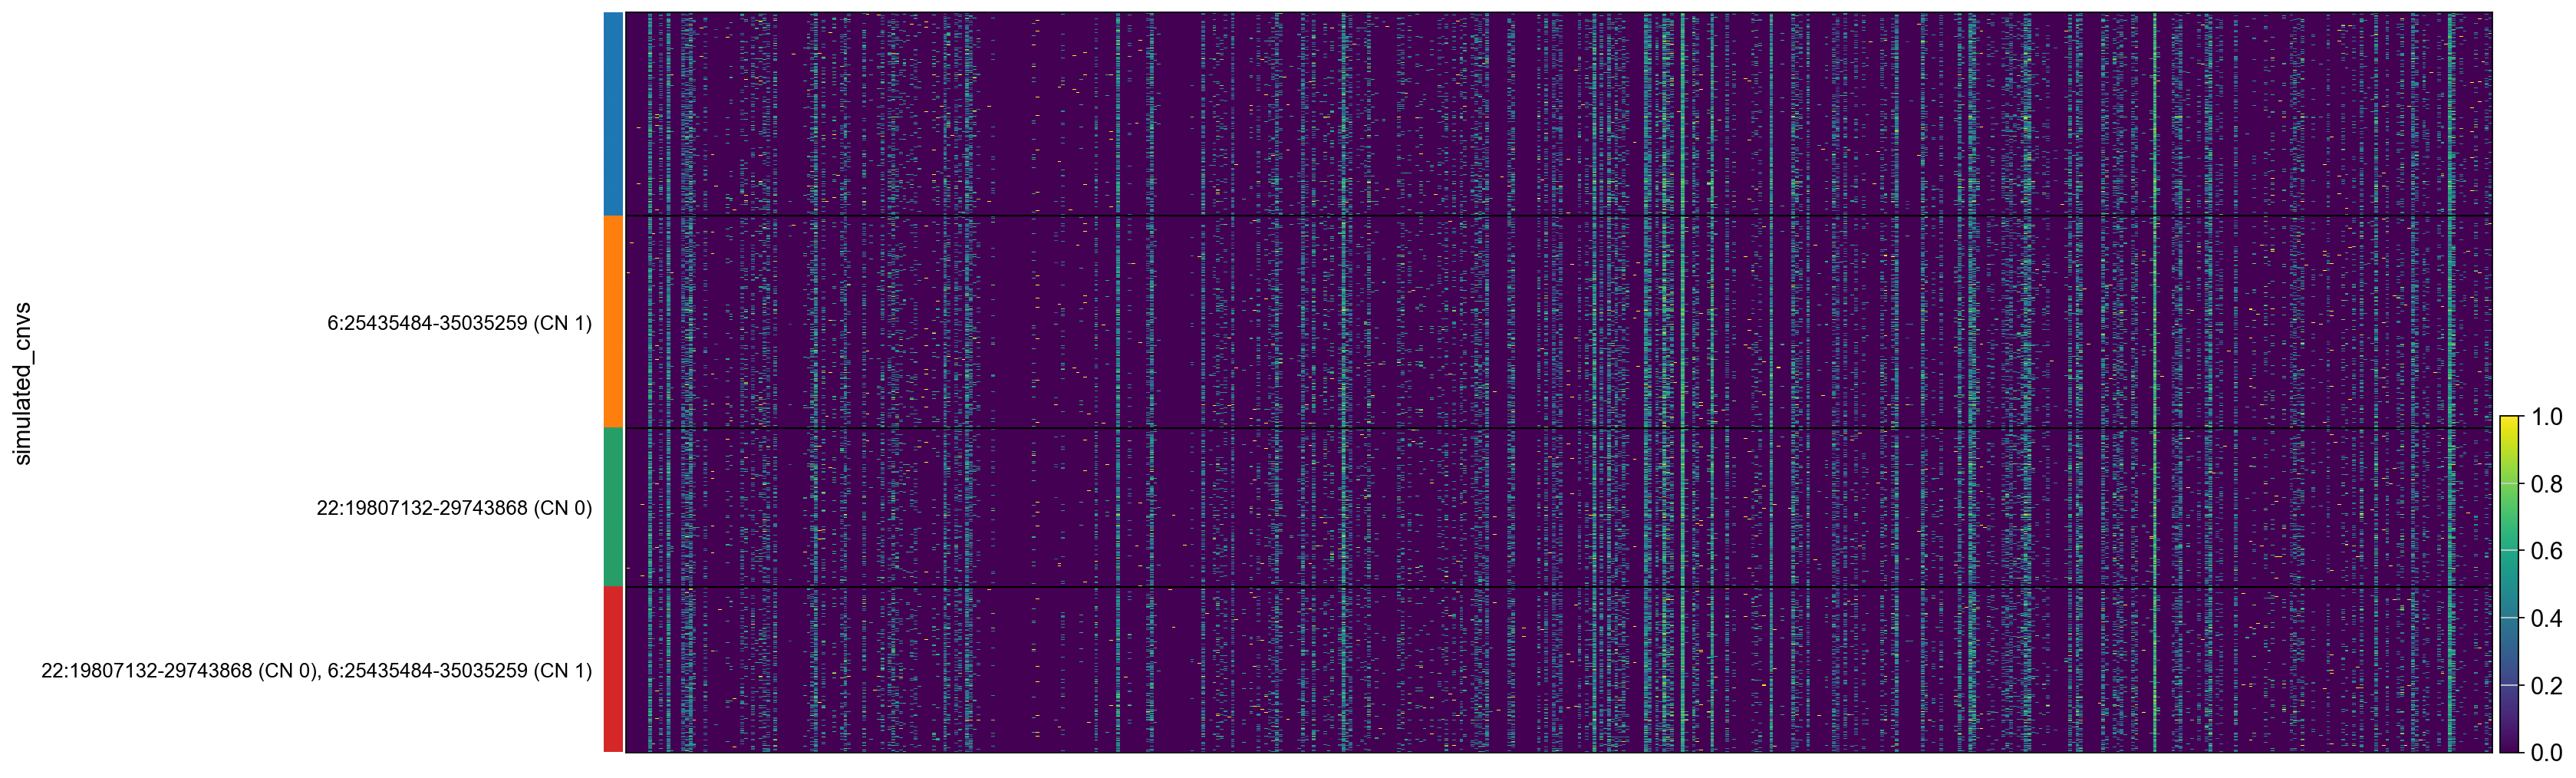

In [13]:
wcnv.plot_cna_heatmap(
    adata,
    cell_type='CD14 monocyte',
    chromosome='chr22'
)

By calling this function, we can choose a specific cell type and a specific chromosome to quickly view how the CNAs impact expression.

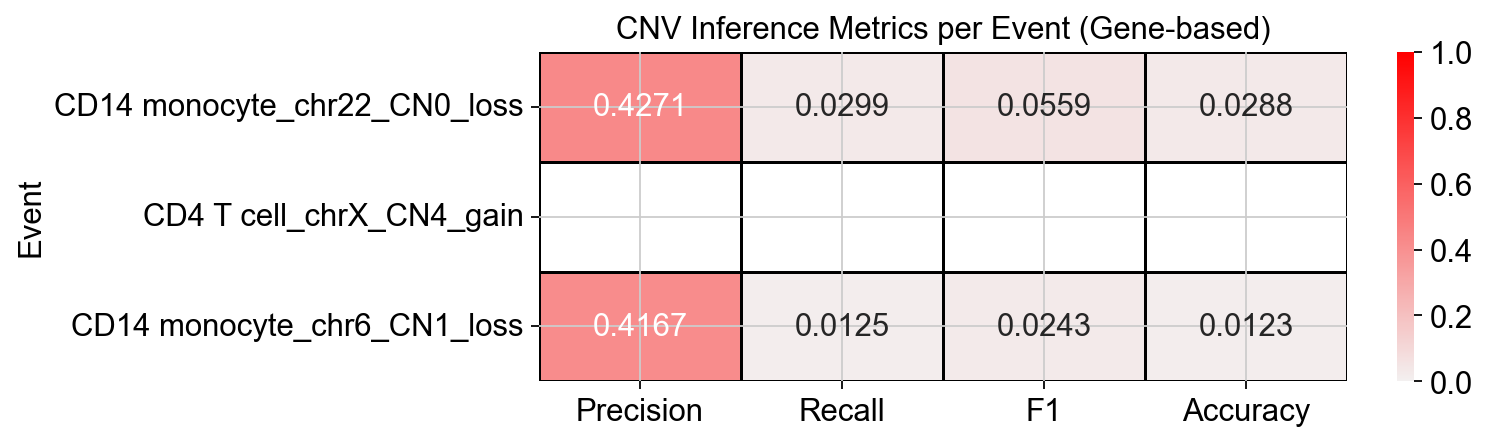

,TP,FP,FN,Precision,Recall,F1,Accuracy
Event,,,,,,,
CD14 monocyte_chr22_CN0_loss,41.0,55.0,1330.0,0.427083,0.029905,0.055896,0.028752
CD4 T cell_chrX_CN4_gain,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD14 monocyte_chr6_CN1_loss,20.0,28.0,1575.0,0.416667,0.012539,0.024346,0.012323


In [14]:
wcnv.evaluate_cnv_inference_aligned(
    adata,
    celltype_key='cell_type',
    cnv_truth_key='simulated_cnvs',
    cnv_inferred_key='cnv',
    threshold_std=1.0
)

Since chrX is excluded during infercnv(), we have no score for it.

For the two evaluated CNV events:

- CD14 monocyte_chr22_CN0_loss shows moderate precision (0.43) but very low recall (0.03), indicating that while most predicted losses were correct, many true events were missed. The F1-score (0.06) reflects this imbalance.

- CD14 monocyte_chr6_CN1_loss has similar precision (0.42) and also low recall (0.01), suggesting even fewer true positives were recovered, leading to a lower F1-score (0.02).

We can set different thresholds (fold-change of cnv score) to determine gain/loss. However, by running the performance evaluation again with a different threshold, we can clearly see that there's a trade-off between precision and accuracy.

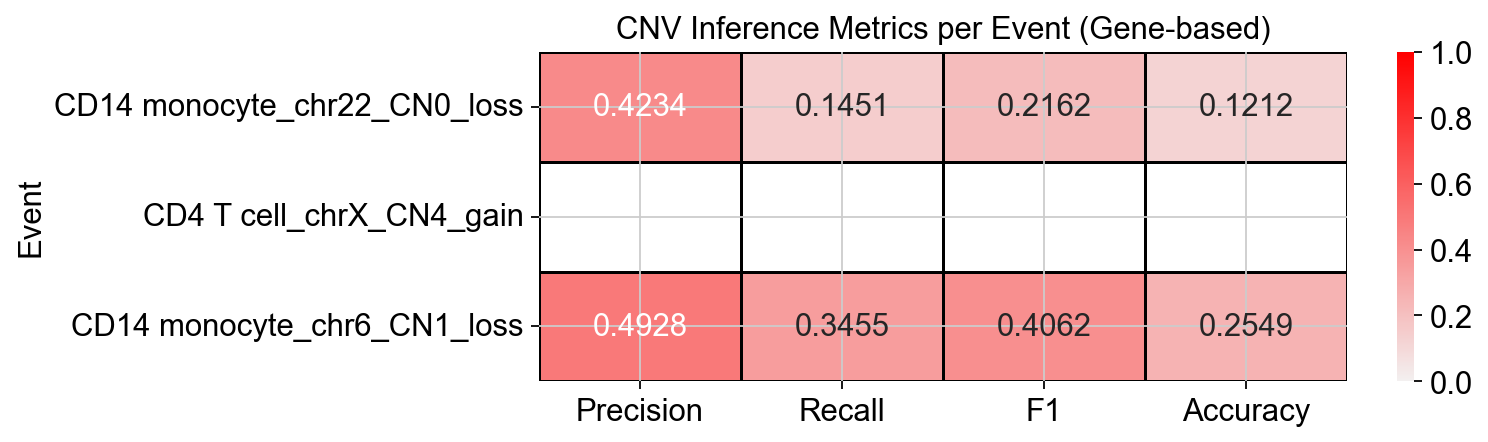

,TP,FP,FN,Precision,Recall,F1,Accuracy
Event,,,,,,,
CD14 monocyte_chr22_CN0_loss,199.0,271.0,1172.0,0.423404,0.145150,0.216186,0.121194
CD4 T cell_chrX_CN4_gain,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD14 monocyte_chr6_CN1_loss,551.0,567.0,1044.0,0.492844,0.345455,0.406192,0.254857


In [15]:
wcnv.evaluate_cnv_inference_aligned(
    adata,
    celltype_key='cell_type',
    cnv_truth_key='simulated_cnvs',
    cnv_inferred_key='cnv',
    threshold_std=0.1
)

When the threshold for calling CNVs is decreased from 1.0 to 0.1 standard deviations, both CNV events show a notable improvement in recall, with a corresponding drop in precision and a substantial increase in F1-score and accuracy. For CD14 monocyte_chr22_CN0_loss, recall increases from 0.03 to 0.15, while precision remains relatively stable (~0.42), leading to a fourfold increase in the F1-score (from 0.06 to 0.22). Similarly, CD14 monocyte_chr6_CN1_loss sees recall improve from 0.01 to 0.35 and F1-score rise from 0.02 to 0.41, with precision slightly increasing to ~0.49.

These results do not exhibit a classic precision-recall trade-off. Instead, lowering the threshold from 1.0 to 0.1 improves both recall and F1-score, while precision remains stable or even increases slightly. This suggests that the original threshold was overly conservative, missing many true CNVs. This lowered threshold better balances sensitivity and specificity, highlighting that appropriate tuning can enhance detection performance.

Thus, when ground truth or reference data is available for a small training dataset, this function can help select an optimal threshold for CNV detection, enabling more accurate downstream analysis.